In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import Dropout, BatchNormalization
import os
import seaborn as sns
from keras.applications import VGG16


In [2]:
print(os.listdir("Data/"))

['test', 'train', 'valid']


In [3]:
print(os.listdir("data/valid/"))

['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


In [4]:
SIZE = 256  #Resize images

#Capture training data and labels into respective lists
train_images = []
train_labels = [] 

for directory_path in glob.glob("Data/train/*"):
    label = directory_path.split("\\")[-1]
    for img_path in glob.glob(os.path.join(directory_path, "*.png")):
        #print(img_path)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
        img = cv2.resize(img, (SIZE, SIZE))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        train_images.append(img)
        train_labels.append(label)

#Convert lists to arrays        
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [5]:
# Capture test/validation data and labels into respective lists

test_images = []
test_labels = [] 
for directory_path1 in glob.glob("Data/valid/*"):
    label1 = directory_path1.split("\\")[-1]
    for img_path1 in glob.glob(os.path.join(directory_path1, "*.png")):
        img1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
        img1 = cv2.resize(img1, (SIZE, SIZE))
        img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
        test_images.append(img1)
        test_labels.append(label1)

#Convert lists to arrays                
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [6]:
print(directory_path1)
print(directory_path)
print(label1)
print(img_path1)

Data/valid\squamous.cell.carcinoma
Data/train\squamous.cell.carcinoma
squamous.cell.carcinoma
Data/valid\squamous.cell.carcinoma\000119.png


In [7]:
#Encode labels from text to integers.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(test_labels)
test_labels_encoded = le.transform(test_labels)
le.fit(train_labels)
train_labels_encoded = le.transform(train_labels)

x_train, y_train, x_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

In [8]:
test_images
test_labels

array(['adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'lar

In [9]:
x_test

array([[[[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  1,   1,   1],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [  1,   1,   1],
         [  0,   0,   0],
         [  0,   0,   0]],

        ...,

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 34,  34,  34],
         [ 40,  40,  40],
         [ 56,  56,  56]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 69,  69,  69],
         [ 89,  89,  89],
         [113, 113, 113]],

        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [127, 127, 127],
        

In [10]:
# Normalize pixel values to between 0 and 1
x_train, x_test = x_train / 255.0, x_test / 255.0

#One hot encode y values for neural network. 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

In [11]:
#Load model wothout classifier/fully connected layers
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(x_train)

features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_RF = features #This is our X input to RF

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [12]:
x_test.shape

(72, 256, 256, 3)

## RANDOM FOREST

In [13]:

from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 200, random_state = 80)

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_features)
print(prediction_RF)
int_prediction_RF = prediction_RF
#Inverse transform to get original label back. 
prediction_RF = le.inverse_transform(prediction_RF)
print(prediction_RF)
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_RF))



3/3 [==============================] - 3s 1s/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 1 0 3 1 3 1 0 3 1 3 1 1 1 1
 1 1 1 1 1 0 1 0 0 0 2 2 2 2 2 2 2 2 2 2 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3]
['adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'squamous.cell.carcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'large.cell.carcinoma' 'adenocarcinoma' 'squamous.cell.carcinoma'
 'large.cell.carcinoma' 'squamous.cell.carcinoma' 'large.cell.carcinoma'
 'adenocarcinoma' 'squamous.cell.carcinoma' 'large.cell.carcinoma'
 'squamous.cell.carcinoma' 'large.cell.carcinoma' 'large.cell.carcinoma'
 'large.cell.carcinoma' 'large.cell.carcinoma' 'large.cell.carcinoma'
 'large.cell.carcinoma' 'large.cell.carcinoma' 

In [15]:
print(X_test_features.shape)
print(prediction_RF)

(72, 32768)
['adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'squamous.cell.carcinoma' 'adenocarcinoma' 'adenocarcinoma'
 'large.cell.carcinoma' 'adenocarcinoma' 'squamous.cell.carcinoma'
 'large.cell.carcinoma' 'squamous.cell.carcinoma' 'large.cell.carcinoma'
 'adenocarcinoma' 'squamous.cell.carcinoma' 'large.cell.carcinoma'
 'squamous.cell.carcinoma' 'large.cell.carcinoma' 'large.cell.carcinoma'
 'large.cell.carcinoma' 'large.cell.carcinoma' 'large.cell.carcinoma'
 'large.cell.carcinoma' 'large.cell.carcinoma' 'large.cell.carcinoma'
 'large.cell.carcinoma' 'adenocarcinoma' 'large.cell.carcinoma'
 'adenocarcinoma' 'adenocarcinoma' 'adenocarcinoma' 'normal' 'normal'
 'normal' 'normal' 'normal' 

<Axes: >

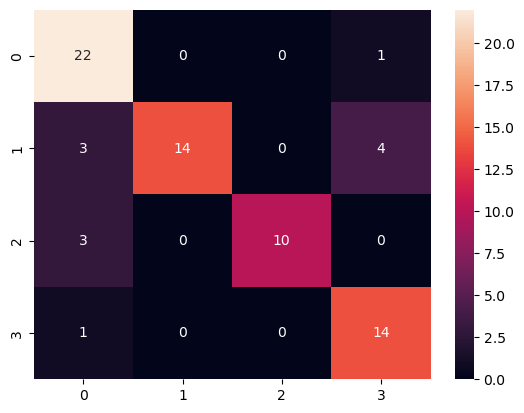

In [16]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_labels, prediction_RF)
#print(cm)
sns.heatmap(cm, annot=True)

1/1 [==============================] - 1s 754ms/step
The prediction for this image is:  ['large.cell.carcinoma']
The actual label for this image is:  large.cell.carcinoma


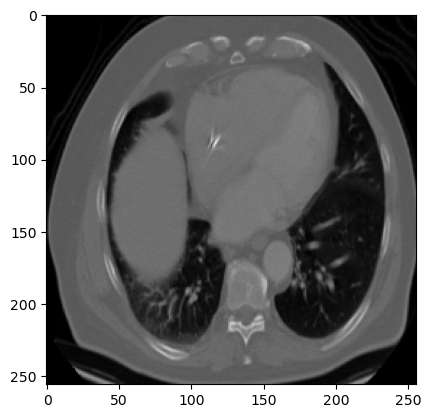

In [17]:
#Check results on a few select images
n=np.random.randint(0, x_test.shape[0])
img = x_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction_RF = RF_model.predict(input_img_features)[0] 
prediction_RF = le.inverse_transform([prediction_RF])  #Reverse the label encoder to original name
print("The prediction for this image is: ", prediction_RF)
print("The actual label for this image is: ", test_labels[n])


## SVM

In [18]:
from sklearn.svm import SVC as svc
SVM_model = svc(kernel ='linear')

# Train the model on training data
SVM_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

3/3 [==============================] - 1s 462ms/step


In [19]:
#Now predict using the trained RF model. 
prediction_SVM = SVM_model.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_SVM = le.inverse_transform(prediction_SVM)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_SVM))

Accuracy =  0.9166666666666666


## MULTINOMIAL Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB

MNBmodel = MultinomialNB()
MNBmodel.fit(X_for_RF, y_train)

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

3/3 [==============================] - 1s 441ms/step


In [22]:
#Now predict using the trained RF model. 
prediction_MNB = MNBmodel.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_MNB = le.inverse_transform(prediction_MNB)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_MNB))

Accuracy =  0.6944444444444444


## Decision Tree Classifier

In [23]:
from sklearn.tree import DecisionTreeClassifier

DTCmodel = DecisionTreeClassifier()

DTCmodel.fit(X_for_RF, y_train)

#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(x_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

3/3 [==============================] - 1s 483ms/step


In [24]:
#Now predict using the trained RF model. 
prediction_DTC = DTCmodel.predict(X_test_features)
#Inverse le transform to get original label back. 
prediction_DTC = le.inverse_transform(prediction_DTC)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, prediction_DTC))

Accuracy =  0.5694444444444444


In [25]:
model1 = RF_model
model2 = SVM_model
model3 = MNBmodel
model4 = DTCmodel

models = [model1, model2, model3, model4]



In [26]:
#final_model = 

In [27]:
predictions = [prediction_RF, prediction_SVM, prediction_MNB, prediction_DTC]
prediction_RF

array(['large.cell.carcinoma'], dtype='<U23')

In [28]:
#predictions = [prediction_RF, prediction_SVM, prediction_MNB, prediction_DTC]
#preds=np.array(predictions)
#ensemble_prediction = np.argmax(preds, axis=1)


In [29]:
int_prediction_SVM = le.transform(prediction_SVM)
int_prediction_SVM

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0,
       0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [30]:

int_prediction_RF , int_prediction_SVM

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 1, 0, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3]))

In [31]:
test_labels_encoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3])

In [32]:
combined_predictions = np.column_stack((int_prediction_RF, int_prediction_SVM))

combined_predictions.shape


(72, 2)

## custom ensemble code

In [ ]:
img = x_test[0]

preds = []
for i in range(2) :
    preds.append(models[i].predict(X_test_features))
    print(models[i].predict(X_test_features))



[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 1 0 3 1 3 1 0 3 1 3 1 1 1 1
 1 1 1 1 1 0 1 0 0 0 2 2 2 2 2 2 2 2 2 2 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3]


[0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 3 0 0 1 1 3 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 3 0 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [ ]:
preds = np.array(preds)

In [ ]:
preds

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 1, 0, 3, 1, 3, 1, 0, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 0,
        0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 3, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3]])

In [ ]:
ff_pred = []
for i in range(len(x_test)) :
    l = []
    for j in range(2) :
        l.append(preds[j][i])

    ff_pred.append(l)

ff_pred

[[0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 3],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [0, 0],
 [3, 3],
 [0, 0],
 [0, 0],
 [1, 1],
 [0, 1],
 [3, 3],
 [1, 1],
 [3, 1],
 [1, 1],
 [0, 1],
 [3, 1],
 [1, 1],
 [3, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [1, 1],
 [0, 1],
 [1, 1],
 [0, 0],
 [0, 3],
 [0, 0],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [2, 2],
 [3, 3],
 [3, 3],
 [3, 3],
 [0, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3],
 [3, 3]]

In [ ]:
final_pred = []
for pred in ff_pred :
    mx = max(pred, key=list(pred).count)
    # print(mx)
    final_pred.append(mx)

print(*final_pred)

0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 1 0 3 1 3 1 0 3 1 3 1 1 1 1 1 1 1 1 1 0 1 0 0 0 2 2 2 2 2 2 2 2 2 2 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3


In [ ]:

final_pred_list = le.inverse_transform(final_pred)

final_pred_list

array(['adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'adenocarcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'squamous.cell.carcinoma',
       'adenocarcinoma', 'adenocarcinoma', 'large.cell.carcinoma',
       'adenocarcinoma', 'squamous.cell.carcinoma',
       'large.cell.carcinoma', 'squamous.cell.carcinoma',
       'large.cell.carcinoma', 'adenocarcinoma',
       'squamous.cell.carcinoma', 'large.cell.carcinoma',
       'squamous.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma',
       'large.cell.carcinoma', 'large.cell.carcinoma', 'a

In [1]:
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(test_labels, final_pred_list) *100, "%")

Accuracy = 90.20777777777778
